# 理論 vs シミュレーション検証

Ridge回帰の**熱力学極限理論**と**有限次元シミュレーション**の一致を検証する。

## 設定

**損失関数**: $L = \frac{1}{2} \sum_{\mu} (y_\mu - w^\top x_\mu)^2 + \frac{\lambda}{2} \|w\|^2$

**秩序パラメータ**:
- $m = \frac{1}{d} w \cdot w^*$ (Student-Teacher重なり)
- $q = \frac{1}{d} |w|^2$ (自己重なり)
- $E_g = \frac{1}{2}(\rho - 2m + q)$ (汎化誤差)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# データセット, モデル, 損失関数
from statphys.dataset import GaussianDataset
from statphys.model import LinearRegression
from statphys.loss import RidgeLoss

# シミュレーション
from statphys.simulation import SimulationConfig, ReplicaSimulation, OnlineSimulation

# 理論
from statphys.theory.online import ODESolver, GaussianLinearMseEquations
from statphys.theory.replica import GaussianLinearRidgeEquations

# 可視化
from statphys.vis import plot_order_params_alpha, plot_order_params_time

# ユーティリティ
from statphys.utils import fix_seed

print("statphys-ml loaded successfully!")

statphys-ml loaded successfully!


In [2]:
# 共通パラメータ
d = 300         # 次元
rho = 1.0       # Teacherノルム ||w*||²/d
sigma_sq = 0.1  # ノイズ分散 σ²
lam = 0.01      # Ridge正則化パラメータ λ
n_seeds = 3     # シード数 (検証用に小さく設定)

# LinearRegressionのデフォルト初期化: W ~ N(0, I), つまり q0 = ||W||²/d ~ 1
init_scale = 1.0  # デフォルト
q0 = init_scale**2  # 初期自己重なり
m0 = 0.0  # 初期teacher-student重なり (独立なガウスの内積)

print(f"次元 d = {d}, ρ = {rho}, σ² = {sigma_sq}, λ = {lam}")
print(f"初期条件: m0 = {m0}, q0 = {q0}")

次元 d = 300, ρ = 1.0, σ² = 0.1, λ = 0.01
初期条件: m0 = 0.0, q0 = 1.0


---
## Part 1: Online Learning

**ODE方程式** ($t = \tau/d$):
$$\frac{dm}{dt} = \eta(\rho - m) - \eta\lambda m, \quad \frac{dq}{dt} = 2\eta(m - q) + \eta^2(\rho - 2m + q + \sigma^2) - 2\eta\lambda q$$

**注意**: 初期条件 $(m_0, q_0) = (0, 1)$ はLinearRegressionのデフォルト初期化 $W \sim \mathcal{N}(0, I)$ に対応。

In [3]:
# Online Learning パラメータ
lr = 0.5
t_max = 10.0
t_steps = 21

# データセット (Teacherを固定)
fix_seed(42)
dataset = GaussianDataset(d=d, rho=rho, eta=sigma_sq)

# 設定: for_online() でOnline用設定を簡潔に作成
online_config = SimulationConfig.for_online(
    t_max=t_max,
    t_steps=t_steps,
    n_seeds=n_seeds,
    lr=lr,
    reg_param=lam,
    verbose=False,
)

# OnlineSimulation でSGDシミュレーション実行
online_sim = OnlineSimulation(online_config)
loss_fn = RidgeLoss(reg_param=lam)

print("Running Online SGD Simulation...")
online_result = online_sim.run(
    dataset=dataset,
    model_class=LinearRegression,
    loss_fn=loss_fn,
)
print("Done!")

Running Online SGD Simulation...


Done!


In [4]:
# 理論計算: GaussianLinearMseEquations + ODESolver
# 重要: 初期条件 init_values=(m0, q0) を指定する
online_eqs = GaussianLinearMseEquations(rho=rho, eta_noise=sigma_sq, lr=lr, reg_param=lam)
solver = ODESolver(equations=online_eqs, order_params=['m', 'q'])
t_eval = np.linspace(0, t_max, t_steps)
theory = solver.solve(t_span=(0, t_max), t_eval=t_eval, init_values=(m0, q0))

m_th = np.array(theory.order_params['m'])
q_th = np.array(theory.order_params['q'])
eg_th = 0.5 * (q_th + rho - 2 * m_th)

print(f"理論 t={t_max}: m={m_th[-1]:.4f}, q={q_th[-1]:.4f}, E_g={eg_th[-1]:.4f}")

理論 t=10.0: m=0.9838, q=1.0017, E_g=0.0171


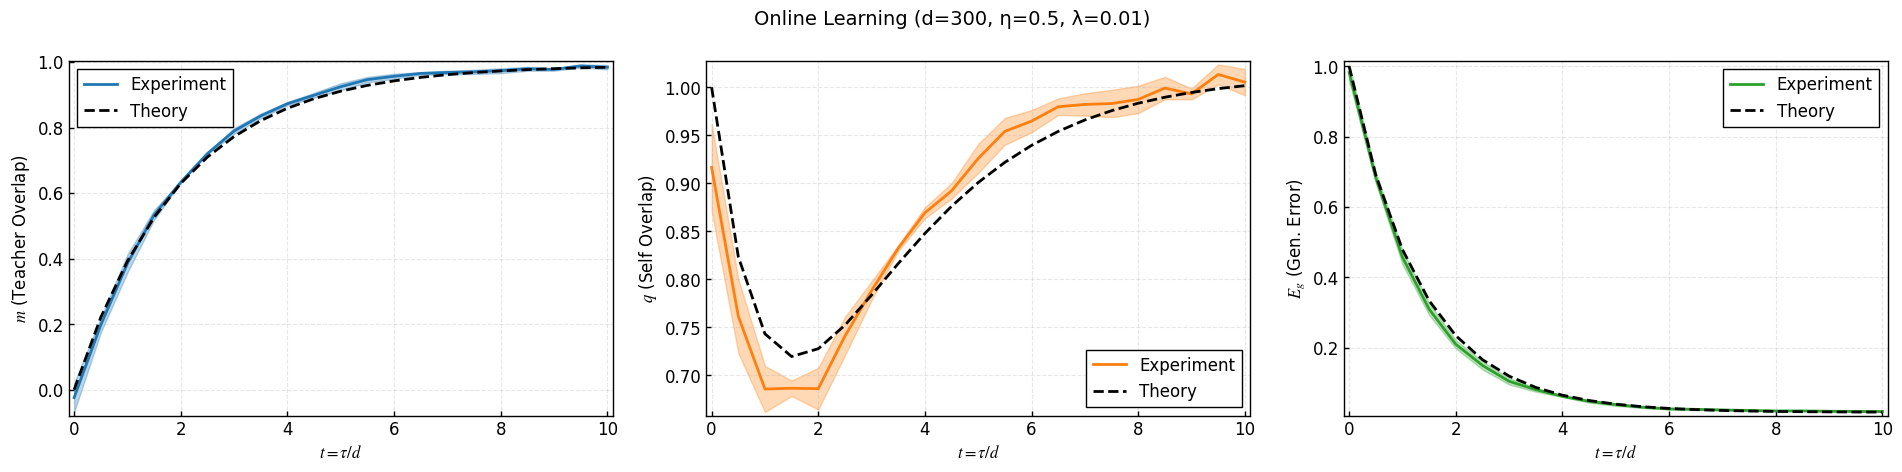

最大誤差: |m|<0.0242, |q|<0.0834


In [5]:
# シミュレーション結果の取得
exp = online_result.experiment_results
traj_mean = np.array(exp['trajectories_mean'])
traj_std = np.array(exp['trajectories_std'])

m_sim, q_sim, eg_sim = traj_mean[:, 0], traj_mean[:, 1], traj_mean[:, 2]
m_std, q_std, eg_std = traj_std[:, 0], traj_std[:, 1], traj_std[:, 2]

# プロット
fig, axes = plot_order_params_time(
    t_values=t_eval, m_mean=m_sim, q_mean=q_sim, eg_mean=eg_sim,
    m_std=m_std, q_std=q_std, eg_std=eg_std,
    m_theory=m_th, q_theory=q_th, eg_theory=eg_th,
    title=f'Online Learning (d={d}, η={lr}, λ={lam})', show=True
)
print(f"最大誤差: |m|<{np.max(np.abs(m_th-m_sim)):.4f}, |q|<{np.max(np.abs(q_th-q_sim)):.4f}")

---
## Part 2: Replica Method

**鞍点方程式** ($\alpha = n/d$):
$$m^2 - (\rho + \lambda + \alpha)m + \alpha\rho = 0$$

In [6]:
# Replica パラメータ
alpha_values = np.arange(0.25, 3.25, 0.2).tolist()

# データセット (Teacherを固定)
fix_seed(42)
dataset = GaussianDataset(d=d, rho=rho, eta=sigma_sq)

# 設定: for_replica() でReplica用設定を簡潔に作成
# AdamWを使い, 高いlrで収束を速くする
replica_config = SimulationConfig.for_replica(
    alpha_values=alpha_values,
    n_seeds=n_seeds,
    lr=0.1,           # AdamWでは高めのlrが有効
    reg_param=lam,
    max_iter=10000,   # 収束には十分
    tol=1e-8,
    patience=200,
    verbose=False,
)

# ReplicaSimulation で勾配降下シミュレーション実行
replica_sim = ReplicaSimulation(replica_config)
loss_fn = RidgeLoss(reg_param=lam)

print("Running Replica (GD) Simulation...")
replica_result = replica_sim.run(
    dataset=dataset,
    model_class=LinearRegression,
    loss_fn=loss_fn,
)
print("Done!")

Running Replica (GD) Simulation...


Done!


In [7]:
# 理論計算: GaussianLinearRidgeEquations.solve_all()
ridge_eqs = GaussianLinearRidgeEquations(rho=rho, eta=sigma_sq, reg_param=lam)
theory_r = ridge_eqs.solve_all(alpha_values)

print("鞍点方程式による理論:")
for i, alpha in enumerate(alpha_values):
    print(f"  α={alpha:.2f}: m={theory_r['m'][i]:.4f}, q={theory_r['q'][i]:.4f}, E_g={theory_r['eg'][i]:.4f}")

鞍点方程式による理論:
  α=0.25: m=0.2467, q=0.2757, E_g=0.3911
  α=0.45: m=0.4421, q=0.5112, E_g=0.3135
  α=0.65: m=0.6328, q=0.7771, E_g=0.2558
  α=0.85: m=0.8079, q=1.1058, E_g=0.2450
  α=1.05: m=0.9256, q=1.3245, E_g=0.2367
  α=1.25: m=0.9660, q=1.2310, E_g=0.1495
  α=1.45: m=0.9792, q=1.1549, E_g=0.0982
  α=1.65: m=0.9852, q=1.1138, E_g=0.0717
  α=1.85: m=0.9885, q=1.0893, E_g=0.0561
  α=2.05: m=0.9906, q=1.0733, E_g=0.0460
  α=2.25: m=0.9921, q=1.0621, E_g=0.0389
  α=2.45: m=0.9932, q=1.0538, E_g=0.0337
  α=2.65: m=0.9940, q=1.0475, E_g=0.0298
  α=2.85: m=0.9946, q=1.0425, E_g=0.0266
  α=3.05: m=0.9952, q=1.0384, E_g=0.0241


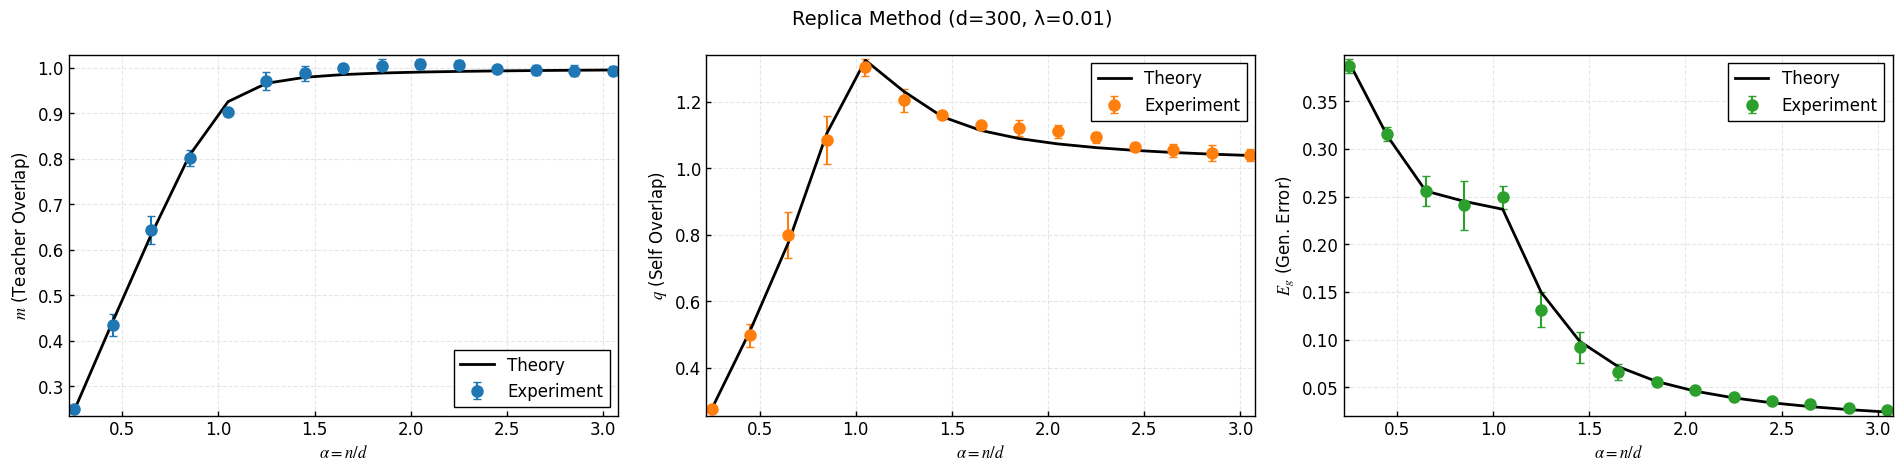

最大誤差: |m|<0.0231, |q|<0.0373


In [8]:
# シミュレーション結果の取得
exp_r = replica_result.experiment_results
order_mean = np.array(exp_r['order_params_mean'])
order_std = np.array(exp_r['order_params_std'])

m_sim_r, q_sim_r, eg_sim_r = order_mean[:, 0], order_mean[:, 1], order_mean[:, 2]
m_std_r, q_std_r, eg_std_r = order_std[:, 0], order_std[:, 1], order_std[:, 2]

# プロット
fig, axes = plot_order_params_alpha(
    alpha_values=alpha_values, m_mean=m_sim_r, q_mean=q_sim_r, eg_mean=eg_sim_r,
    m_std=m_std_r, q_std=q_std_r, eg_std=eg_std_r,
    m_theory=theory_r['m'], q_theory=theory_r['q'], eg_theory=theory_r['eg'],
    title=f'Replica Method (d={d}, λ={lam})', show=True
)
print(f"最大誤差: |m|<{np.max(np.abs(theory_r['m']-m_sim_r)):.4f}, |q|<{np.max(np.abs(theory_r['q']-q_sim_r)):.4f}")

---
## まとめ

- **Online Learning**: ODE理論がSGDシミュレーションと一致 ($d \to \infty$)
- **Replica Method**: 鞍点方程式が勾配降下法の平衡解と一致 ($n, d \to \infty$, $\alpha$ 固定)

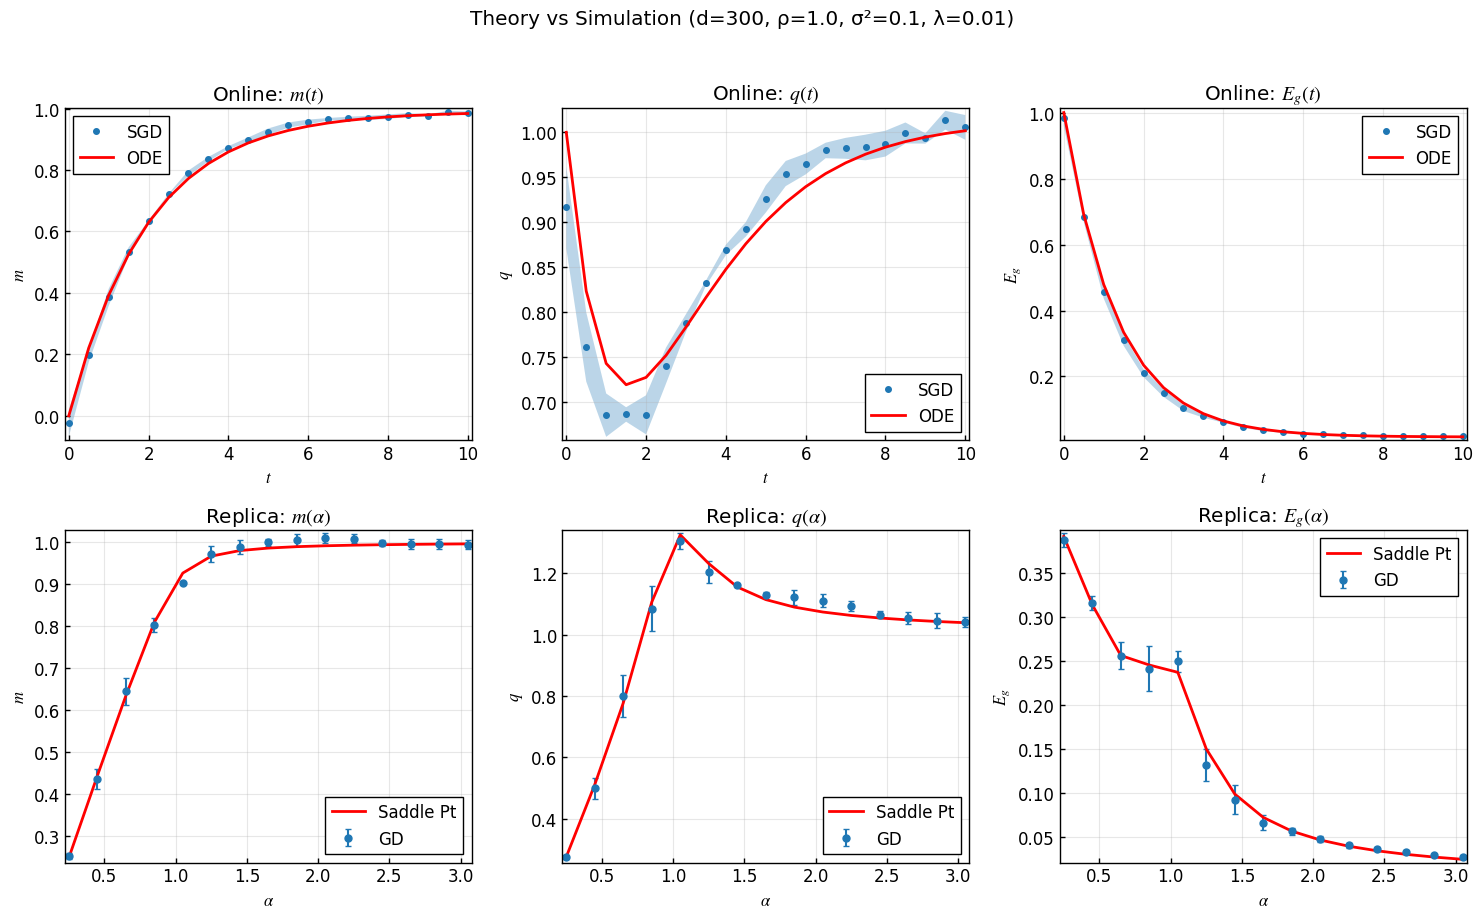

検証完了
Online:  |m|<0.0242, |q|<0.0834
Replica: |m|<0.0231, |q|<0.0373


In [9]:
# 統合プロット
fig, axes = plt.subplots(2, 3, figsize=(15, 9))

# Online (上段)
for i, (mean, std, th, label) in enumerate([
    (m_sim, m_std, m_th, 'm'), (q_sim, q_std, q_th, 'q'), (eg_sim, eg_std, eg_th, 'E_g')
]):
    axes[0,i].fill_between(t_eval, mean-std, mean+std, alpha=0.3)
    axes[0,i].plot(t_eval, mean, 'o', ms=4, label='SGD')
    axes[0,i].plot(t_eval, th, '-', lw=2, c='red', label='ODE')
    axes[0,i].set_xlabel('$t$'); axes[0,i].set_ylabel(f'${label}$')
    axes[0,i].set_title(f'Online: ${label}(t)$'); axes[0,i].legend(); axes[0,i].grid(alpha=0.3)

# Replica (下段)
for i, (mean, std, th, label) in enumerate([
    (m_sim_r, m_std_r, theory_r['m'], 'm'), (q_sim_r, q_std_r, theory_r['q'], 'q'), 
    (eg_sim_r, eg_std_r, theory_r['eg'], 'E_g')
]):
    axes[1,i].errorbar(alpha_values, mean, yerr=std, fmt='o', ms=5, capsize=2, label='GD')
    axes[1,i].plot(alpha_values, th, '-', lw=2, c='red', label='Saddle Pt')
    axes[1,i].set_xlabel(r'$\alpha$'); axes[1,i].set_ylabel(f'${label}$')
    axes[1,i].set_title(f'Replica: ${label}(\\alpha)$'); axes[1,i].legend(); axes[1,i].grid(alpha=0.3)

plt.suptitle(f'Theory vs Simulation (d={d}, ρ={rho}, σ²={sigma_sq}, λ={lam})', y=1.02)
plt.tight_layout()
plt.savefig('verification_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("="*60)
print("検証完了")
print(f"Online:  |m|<{np.max(np.abs(m_th-m_sim)):.4f}, |q|<{np.max(np.abs(q_th-q_sim)):.4f}")
print(f"Replica: |m|<{np.max(np.abs(theory_r['m']-m_sim_r)):.4f}, |q|<{np.max(np.abs(theory_r['q']-q_sim_r)):.4f}")
print("="*60)